<a href="https://colab.research.google.com/github/Muhammadsulton1/MIPT_Data_analys/blob/main/Lesson_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Семинар 10 (неделя 12): Регрессионный анализ
=====

In [ ]:
# Импорт библиотек для работы со статистикой
import pandas as pd
import numpy as np

# Импорт библиотек для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

# Стиль для графиков
plt.style.use('ggplot')
%matplotlib inline

_Основы линейной регрессии на Хабре:_
https://habr.com/ru/post/514818/

### Предсказание цены домов в Альбукерке

Анализируемые данные являются случайной выборкой из записей о перепродажах домов, совершенных в 1993 году в городе Альбукерке, США. Описание переменных:

__PRICE__ - продажная цена в сотнях долларов
__SQFT__ - площадь в квадратных футах
__AGE__ - возраст дома (количество лет)
__FEATS__ - количество дополнительных удобств из 11 возможных
- (dishwasher, refrigerator, microwave, disposer, washer, intercom, skylight(s), compactor, dryer, handicap fit, cable TV access)

__NE__ - дом расположен в престижном районе на северо-востоке города (1), или нет (0)
__CUST__ - тип постройки: был ли дом обычной постройки (0) или нет (1)
__COR__ - расположение дома на углу (1) или нет (0)
__TAX__ - величина налогов за владение домом ($)

In [ ]:
AHP = pd.read_csv('Albuquerque Home Prices.txt', sep='\t')

In [ ]:
AHP

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13,7,1,1,0,1639
1,2080,2600,-9999,4,1,1,0,1088
2,2150,2664,6,5,1,1,0,1193
3,2150,2921,3,6,1,1,0,1635
4,1999,2580,4,4,1,1,0,1732
...,...,...,...,...,...,...,...,...
112,872,1229,6,3,0,0,0,721
113,870,1273,4,4,0,0,0,638
114,869,1165,7,4,0,0,0,694
115,766,1200,7,4,0,0,1,634


In [ ]:
AHP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PRICE   117 non-null    int64
 1   SQFT    117 non-null    int64
 2   AGE     117 non-null    int64
 3   FEATS   117 non-null    int64
 4   NE      117 non-null    int64
 5   CUST    117 non-null    int64
 6   COR     117 non-null    int64
 7   TAX     117 non-null    int64
dtypes: int64(8)
memory usage: 7.4 KB


In [ ]:
AHP.isnull().sum()

PRICE    0
SQFT     0
AGE      0
FEATS    0
NE       0
CUST     0
COR      0
TAX      0
dtype: int64

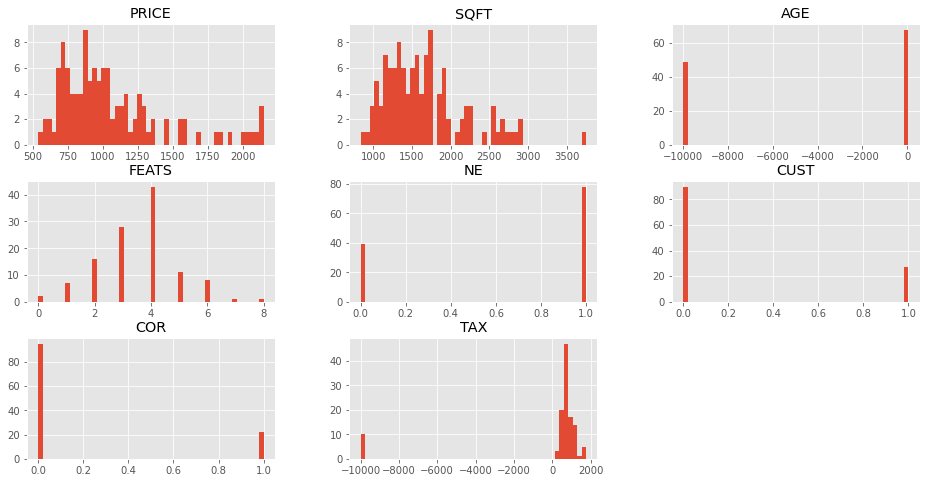

In [ ]:
AHP.hist( figsize = (16, 8), bins = 50 );

In [ ]:
AHP = AHP.replace(-9999, np.nan)
AHP

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0
...,...,...,...,...,...,...,...,...
112,872,1229,6.0,3,0,0,0,721.0
113,870,1273,4.0,4,0,0,0,638.0
114,869,1165,7.0,4,0,0,0,694.0
115,766,1200,7.0,4,0,0,1,634.0


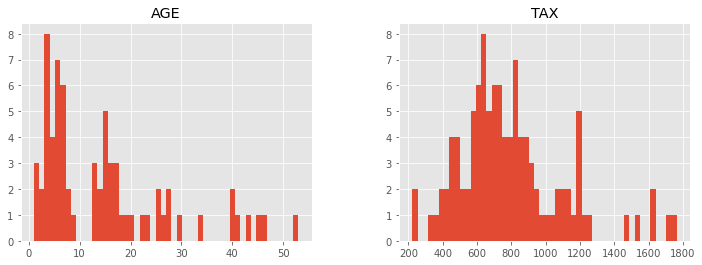

In [ ]:
AHP[['AGE', 'TAX']].hist( figsize = (12, 4), bins = 50 );

Прежде, чем строить модель, нужно решить вопрос с пропущенными значениями. Сначала посчитаем, сколько строчек их содержат.

In [ ]:
AHP.isnull().sum()

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX      10
dtype: int64

Таким образом, около половины наших данных содержат хотя бы одно пропущенное значение. Учитывая то, что данных относительно мало, выбрасывать все такие строчки, было бы слишком расточительно. Источниками пропущенных значений являются колонки ```AGE``` и ```TAX```. Раз в колонке ```AGE``` так много пропусков, то проще её будет убрать из анализа, чем пытаться заделать эти дырки.

In [ ]:
del AHP['AGE']

In [ ]:
AHP

,PRICE,SQFT,FEATS,NE,CUST,COR,TAX
0,2050,2650,7,1,1,0,1639.0
1,2080,2600,4,1,1,0,1088.0
2,2150,2664,5,1,1,0,1193.0
3,2150,2921,6,1,1,0,1635.0
4,1999,2580,4,1,1,0,1732.0
...,...,...,...,...,...,...,...
112,872,1229,3,0,0,0,721.0
113,870,1273,4,0,0,0,638.0
114,869,1165,4,0,0,0,694.0
115,766,1200,4,0,0,1,634.0


А колонку ```TAX``` можно попробовать починить. Чтобы это сделать, сначала посмотрим, как выглядит распределение этой колонки.

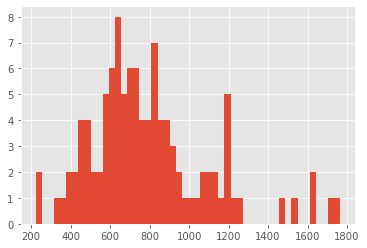

In [ ]:
AHP['TAX'].hist( bins = 50 );

Раз распределение похоже на нормальное, то можно заменить пропуски на среднее значение этой колонки:

In [ ]:
AHP['TAX'] = AHP['TAX'].fillna(AHP['TAX'].mean())

Убедимся, что все проблемы с пропусками устранены:

In [ ]:
AHP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRICE   117 non-null    int64  
 1   SQFT    117 non-null    int64  
 2   FEATS   117 non-null    int64  
 3   NE      117 non-null    int64  
 4   CUST    117 non-null    int64  
 5   COR     117 non-null    int64  
 6   TAX     117 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 6.5 KB


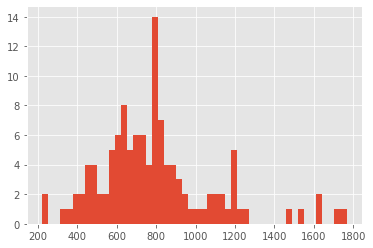

In [ ]:
AHP['TAX'].hist( bins = 50 );

## Построение модели: линейная регрессия

Теперь можно переходить непосредственно к построению модели.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X = AHP.drop('PRICE', axis = 1)
y = AHP['PRICE']

In [ ]:
X

,SQFT,FEATS,NE,CUST,COR,TAX
0,2650,7,1,1,0,1639.0
1,2600,4,1,1,0,1088.0
2,2664,5,1,1,0,1193.0
3,2921,6,1,1,0,1635.0
4,2580,4,1,1,0,1732.0
...,...,...,...,...,...,...
112,1229,3,0,0,0,721.0
113,1273,4,0,0,0,638.0
114,1165,4,0,0,0,694.0
115,1200,4,0,0,1,634.0


In [ ]:
y

0      2050
1      2080
2      2150
3      2150
4      1999
       ... 
112     872
113     870
114     869
115     766
116     739
Name: PRICE, Length: 117, dtype: int64

In [ ]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Считаем качество модели (коэффициент $R^2$).

In [ ]:
print('R^2: {0}'.format(model.score(X, y)))

R^2: 0.8022436103807493


Выведем регрессионные коэффициенты от метода ```model.coef_``` и свободный член от метода ```model.intercept_```.

In [ ]:
coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(),
                        [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,83.175919
1,SQFT,0.291978
2,FEATS,12.176743
3,NE,8.011604
4,CUST,133.014342
5,COR,-65.800841
6,TAX,0.541942


К сожалению, в ```sklearn``` не предусмотрена процедура определения статистической значимости регрессионных коэффициентов. Поэтому нужно это делать либо руками, вооружившись знанием о распределении коэффициентов, либо воспользовавшись моделью из пакета ```statsmodels```.

In [ ]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(),
                            [model.intercept_] + model.coef_.tolist()),
                        columns=['predictor', 'coef'])

    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef

regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,83.175919,1.895059e-01
1,SQFT,0.291978,2.580075e-06
2,FEATS,12.176743,3.419172e-01
3,NE,8.011604,8.190403e-01
4,CUST,133.014342,3.454095e-03
5,COR,-65.800841,1.168611e-01
6,TAX,0.541942,4.972770e-07


Как интерпретировать модель? У нас есть 3 значимых предиктора: ```SQFT```, ```CUST``` и ```TAX```.  Значение коэффициента говорит, на сколько вырастет значение сигнала при увеличении предиктора на одну единицу. Смысл первых двух коэффициентов понятен: площадь и специальный вид постройки ожидаемо влияют на цену. Но есть ли смысл включать в предсказание цены дома налог с этого же дома? Ведь налог, как и цена, также начисляется исходя из похожих предикторов. Они должны сильно коррелировать. И действительно. Построим таблицу парных корреляций предикторов.

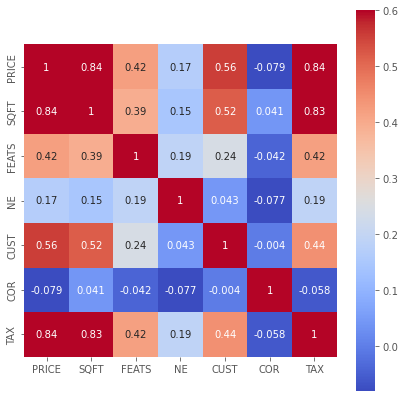

In [ ]:
plt.figure(figsize = (7, 7))
sns.heatmap(AHP.corr(), cmap = 'coolwarm', vmax = 0.6, square = True, annot = True);

Налоги сильно коррелируют с площадью. Предлагается откинуть налоги.

In [ ]:
X = AHP[['SQFT', 'FEATS', 'CUST']]
model.fit(X, y)
print(model.score(X, y))
regression_coef(model, X, y)

0.7398546894225253


,predictor,coef,pvalue
0,intercept,65.959766,0.345472
1,SQFT,0.527919,0.000000
2,FEATS,25.979118,0.067760
3,CUST,138.534915,0.006877


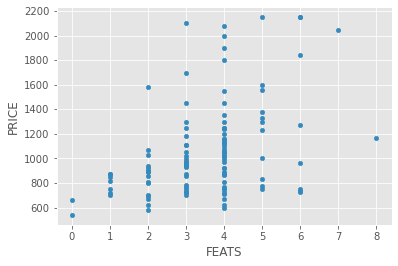

In [ ]:
AHP.plot.scatter(x='FEATS', y='PRICE');

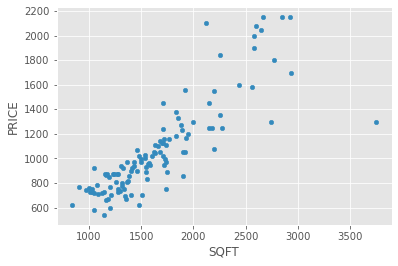

In [ ]:
AHP.plot.scatter( x = 'SQFT', y = 'PRICE');

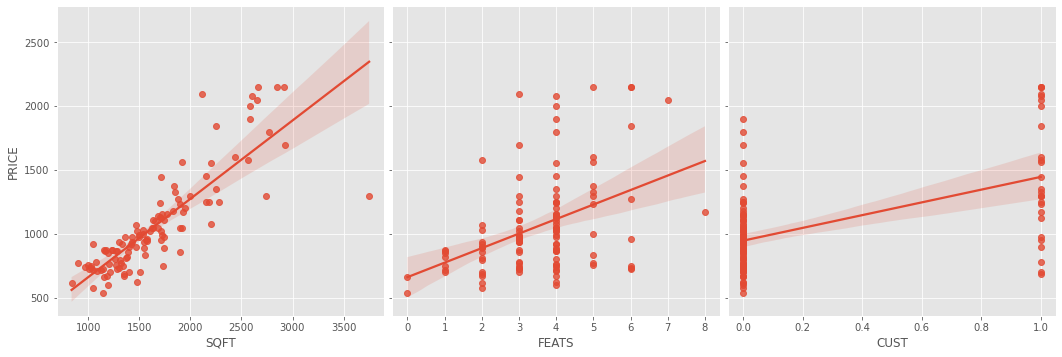

In [ ]:
sns.pairplot(AHP,
             y_vars = 'PRICE',
             x_vars = ['SQFT', 'FEATS', 'CUST'],
             height = 5,
             kind = 'reg',
            );

---
## ПРИМЕР

In [ ]:
ADV = pd.read_csv('Advertising.csv', sep = ';', index_col = 0)
ADV.tail()

,TV,Radio,Newspaper,Sales
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5
200,232.1,8.6,8.7,13.4


В нашей выборке мы имеем 200 наблюдений (200 разных рынков с разным объёмом рекламы). Описание колонок:

__TV__ - доллары, потраченные на ТВ рекламу для одного продукта на данном рынке (в тысячах долларов)
__Radio__ - доллары, потраченные на радио рекламу
__Newspaper__ - доллары, потраченные на рекламу в газетах
__Sales__ - продажи продукта на данном рынке (в тысячах штук)


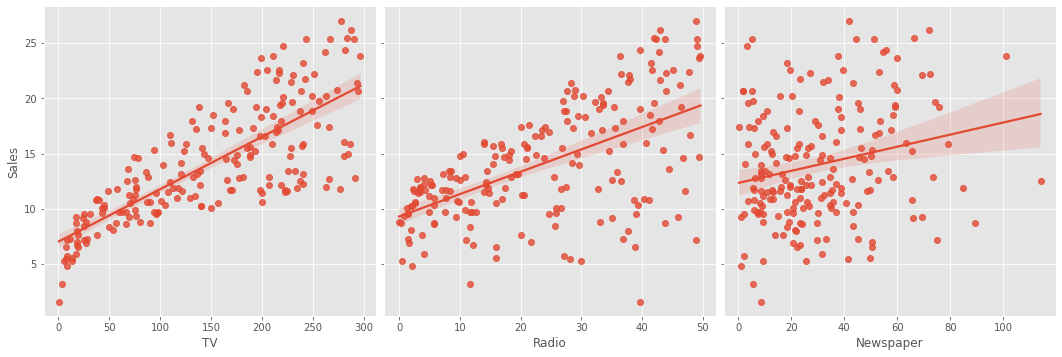

In [ ]:
sns.pairplot(ADV,
             y_vars = 'Sales',
             x_vars = ['TV', 'Radio', 'Newspaper'],
             height = 5,
             kind='reg'
            );

Для начала давайте поговорим только про рекламу на TV. Оценим параметры модели

$$
Sales_i = \beta_0 + \beta_1 \cdot TV_i + \varepsilon_i
$$

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
model = smf.ols('Sales ~ TV', data = ADV)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Fri, 19 Nov 2021   Prob (F-statistic):           1.47e-42
Time:                        11:16:13   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

In [ ]:
res.params

Intercept    7.032594
TV           0.047537
dtype: float64

Переменная $TV$ значима, так как $p$-значение для проверки гипотезы о том, что она равна нулю оказалось очень маленьким, наблюдаемое значение статистики $17.668$. Оно лежит глубоко в хвосте нашего распределения.
Получившееся уравнение
$$
Sales_i = 7.033 + 0.047 \cdot TV_i
$$
можно проинтерпретировать так, что каждые дополнительные $1000$ долларов, потраченные на рекламу по телевизору, увеличивают продажы на $47.537$ товаров.


In [ ]:
X_new = pd.DataFrame({'TV':[50]})
X_new

,TV
0,50


In [ ]:
res.predict(X_new)

0    9.409426
dtype: float64

In [ ]:
7.033+0.047*50

9.383000000000001


> Мы можем так интерпретировать значение коэффициента, если выполняются предпослыки линейной регрессии. Например, первая предпослыка говорит о том, что мы должны были верно специфицировать модель.

> Если модель специфицирована неверно, у нас есть проблемы.

> Мы получаем корректные оценки стандартных ошибок в ситуации, когда ошибки независимо одинаково распределены с одинаковой дисперсией. Если это не так, оценки ошибок искажены.

## Парная регрессия в логарифмах
У нашей модели явно есть проблемы со спецификацией. Давайте попробуем их исправить. Если взглянуть на график того, как между собой взаимосвязаны реклама по TV и продажи, можно заметить нелинейную зависимость, похожую на логарифмическую.

In [ ]:
ADV['ln_TV'] = ADV['TV'].apply(np.log)
ADV['ln_Sales'] = ADV['Sales'].apply(np.log)
ADV

,TV,Radio,Newspaper,Sales,ln_Sales,ln_TV
1,230.1,37.8,69.2,22.1,3.095578,5.438514
2,44.5,39.3,45.1,10.4,2.341806,3.795489
3,17.2,45.9,69.3,9.3,2.230014,2.844909
4,151.5,41.3,58.5,18.5,2.917771,5.020586
5,180.8,10.8,58.4,12.9,2.557227,5.197391
...,...,...,...,...,...,...
196,38.2,3.7,13.8,7.6,2.028148,3.642836
197,94.2,4.9,8.1,9.7,2.272126,4.545420
198,177.0,9.3,6.4,12.8,2.549445,5.176150
199,283.6,42.0,66.2,25.5,3.238678,5.647565


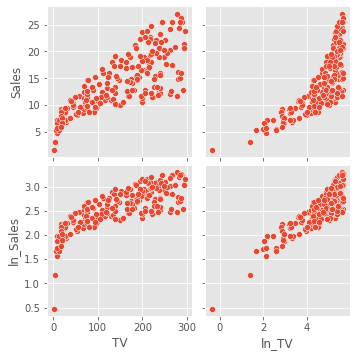

In [ ]:
sns.pairplot(ADV,
             y_vars = ['Sales', 'ln_Sales'],
             x_vars = ['TV', 'ln_TV'],
             height = 2.5,
             diag_kind = None
            );

In [ ]:
ADV = ADV[ADV.Sales > ADV.Sales.quantile(0.01)]

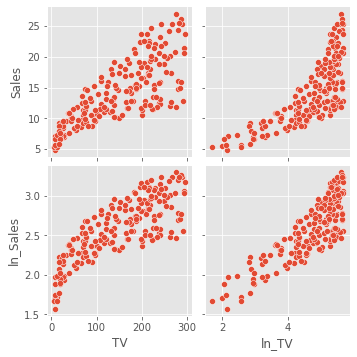

In [ ]:
sns.pairplot(ADV,
             y_vars = ['Sales', 'ln_Sales'],
             x_vars = ['TV', 'ln_TV'],
             height = 2.5,
             diag_kind = None
            );

Оценим параметры модели

$$
\ln Sales_i = \beta_0 + \beta_1 \cdot \ln TV_i + \varepsilon_i
$$

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('ln_Sales ~ ln_TV', data = ADV)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     435.1
Date:                Fri, 19 Nov 2021   Prob (F-statistic):           1.16e-51
Time:                        11:24:33   Log-Likelihood:                 29.332
No. Observations:                 198   AIC:                            -54.66
Df Residuals:                     196   BIC:                            -48.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9757      0.078     12.443      0.0

Переменная снова значима. $R^2$ подрос. Все коэффициенты в моделях, где целевые и объясняющие переменные взяты в логарифмах, интерпретируются в процентных изменениях. Например, коэффициент $0.34$ можно проинтерпретировать как то, на сколько процентов увеличутся продажи, при изменении трат на рекламу по телевизору на $1\%$.

In [ ]:
xs = np.linspace(1, 300, 200)
X_new = pd.DataFrame({ 'ln_TV': np.log(xs) })
preds = np.exp(res.predict(X_new))

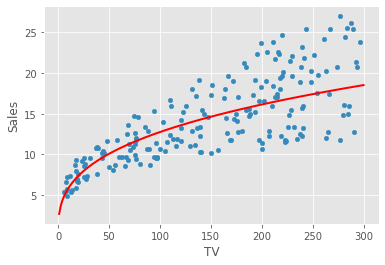

In [ ]:
ADV.plot(kind = 'scatter', x = 'TV', y = 'Sales')
plt.plot(xs, preds, c = 'red', linewidth = 2);

__Выводы:__
- Тратить деньги на рекламу в газетах неэффективно. Гипотеза о том, что коэффициент перед этой переменной равен нулю, не отвергается.
- Реклама по телевидению обладает убывающей отдачей от масштаба. Коэффициент перед логарифмом получился меньше единицы. Этот канал оказывается в плане рекламы самым эффективным.
- Канал, связанный с радио, судя по всему, недоиспользуется. Здравый смысл и микроэкономика подсказывают, что от него тоже логично ожидать убывающую от масштаба отдачу. Однако в данных мы видим, что она линейная.

## Множественная регрессия
Оценим уравнение

$$
\ln Sales_i = \beta_0 + \beta_1 \cdot \ln TV_i + \beta_2 \cdot Radio_i + \beta_3 \cdot Newspaper_i + \varepsilon_i
$$

In [ ]:
model = smf.ols('ln_Sales ~ ln_TV + Radio + Newspaper', data = ADV)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2959.
Date:                Thu, 18 Nov 2021   Prob (F-statistic):          1.17e-161
Time:                        19:56:06   Log-Likelihood:                 294.22
No. Observations:                 198   AIC:                            -580.4
Df Residuals:                     194   BIC:                            -567.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6661      0.022     30.446      0.0

Уравнение значимо в целом, значение F-статистики попадает глубоко в хвост.
Коэффициент перед Newspaper отрицательный и незначимый.
Если модель специфицирована верно и выполнены все предпосылки, мы можем сделать вывод, что траты на рекламу в газетах никак не повышают продажи и от них можно отказаться.

# Полиноминальная регрессия и Переобучение

![](https://upload.wikimedia.org/wikipedia/commons/6/68/Overfitted_Data.png)

In [ ]:
# Формируем numpy списки
X = ADV[['TV', 'Radio', 'Newspaper']].values
y = ADV['Sales'].values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape, X_test.shape

((158, 3), (40, 3))

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [ ]:
model.fit(X_train, y_train)
model.coef_

array([ 0.04439146,  0.19696691, -0.00350995])

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([ 7.95753313, 15.63425932, 12.88448471, 19.26048068, 10.69469822,
       10.89655161, 18.37179161, 21.490682  , 10.11136767, 17.75176729,
       14.18076181, 20.94962589, 21.41491912,  8.77940481, 13.10855521,
       15.16002605, 19.35532248, 12.37300619, 12.64876248, 15.03590695,
       16.39030132, 17.54630163,  5.75965308,  6.19717605,  9.82299416,
       18.98240266,  7.00028196, 13.84773072,  6.56302295, 12.03410753,
       21.24133463,  4.52914526,  9.17012629, 10.29292094,  8.24902801,
       18.73035918, 12.50631741, 11.89494892, 14.24522043,  9.92084341])

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
r2_score(y_test, y_pred)

0.8917729658546795

In [ ]:
mean_absolute_error(y_test, y_pred)

1.249311326707962

In [ ]:
y_pred = model.predict(X_train)
print(r2_score(y_train, y_pred))
print(mean_absolute_error(y_train, y_pred))

0.9115589530832945
1.1753639166436731


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

poly = PolynomialFeatures(degree = 10) # попробовать degree = 1, 3, 5, 10
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [ ]:
#X_train[:10],
X_train.shape

(158, 286)

In [ ]:
model.fit(X_train, y_train)
model.coef_[:10]

array([ 5.30090925e-12,  1.51363263e-15,  6.66380226e-13,  9.42318550e-14,
       -4.79167851e-13, -7.60218210e-14, -1.62905550e-13,  1.01357838e-14,
       -1.90964115e-15, -5.29846188e-14])

In [ ]:
y_pred = model.predict(X_train)

print("Качество модели на тренировочном наборе:")
print( 'R^2: {0}'.format( r2_score(y_train, y_pred) ) )
print( 'MAE: {0}'.format( mean_absolute_error(y_train, y_pred) ) )

Качество модели на тренировочном наборе:
R^2: 0.9881531275035246
MAE: 0.35809844522734446


In [ ]:
y_pred = model.predict(X_test)

print("Качество модели на тестовом наборе:")
print( 'R^2: {0}'.format( r2_score(y_test, y_pred) ) )
print( 'MAE: {0}'.format( mean_absolute_error(y_test, y_pred) ) )

Качество модели на тестовом наборе:
R^2: -1458262411.697007
MAE: 33859.60523855206


# Кросс-валидация

![](https://wiki.loginom.ru/images/cross-validation.svg)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = LinearRegression()

cv_results = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'r2')
cv_results

array([0.82721394, 0.91394096, 0.91642977, 0.93555457, 0.85009041])

In [ ]:
cv_results.mean()

0.8886459317942798

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Качество модели на тестовом наборе:")
print( 'R^2: {0}'.format( r2_score(y_test, y_pred) ) )

Качество модели на тестовом наборе:
R^2: 0.8917729658546795


---
---
# Домашнее задание

Используя датасет ```pimdb.csv```, построить модель для предстказания рейтинга фильма __ImdbRating__.